In [11]:
!nvidia-smi | head -n 32

Sun Apr  1 19:37:13 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.111                Driver Version: 384.111                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:05:00.0 Off |                  N/A |
| 24%   42C    P8    19W / 250W |   9026MiB / 11172MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:42:00.0 Off |                  N/A |
| 65%   86C    P2   135W / 250W |   9417MiB / 11172MiB |    100%      Default |
+-------------------------------+----------------------+----------------------+
        

In [2]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import numpy as np
import sys
import os
sys.path.append('../common/')
import utils
import nets
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import time
import random
plt.style.use('ggplot')
import traceback
import math
print(tf.__version__)

1.3.0


In [7]:
MODEL_NAME = '3_22_rpn_sigmoid_roi_rpn_joint'

In [8]:
#REMOTE_WORKER = "grpc://10.109.246.6:2222"
#cluster = tf.train.ClusterSpec({"local": ["10.109.246.6:2222"]})

In [9]:
import pickle
with open('../data/train_val.pkl','rb') as fhdl:
    (train_images,train_bbs,val_images,val_bbs) = pickle.load(fhdl)

In [10]:
BATCH_SIZE = 1

In [77]:
def rpn_layer(feature_map,k=9,ramda=10):
    mask_input = tf.placeholder(tf.float32,shape=(BATCH_SIZE,None,None,1 * k),name='mask_input')
    cls_input = tf.placeholder(tf.float32,shape=(BATCH_SIZE,None,None,k),name='cls_input')
    reg_input = tf.placeholder(tf.float32,shape=(BATCH_SIZE,None,None,k * 4),name='reg_input')
    
    with tf.variable_scope('rpn_conv'):
        rpn_hidden = tf.layers.conv2d(feature_map,filters=256,kernel_size=(3,3),padding='same',activation=tf.nn.relu,name='hidden')
        cls_result = tf.layers.conv2d(rpn_hidden,filters=k,kernel_size=(1,1),padding='same',activation=None,name='cls_conv') # [BATCH_SIZE,None,None,4 * k]
        reg_result = tf.layers.conv2d(rpn_hidden,filters=4 * k,kernel_size=(1,1),padding='same',activation=None,name='reg_conv') # [BATCH_SIZE,None,None,4 * k]

    with tf.variable_scope('rpn_loss'):
        #cls_input_reshape = tf.reshape(cls_input,shape=(-1,2))
        #cls_result_reshape = tf.reshape(cls_result,shape=(-1,2))

        #reg_input_reshape = tf.reshape(reg_input,shape=(BATCH_SIZE,-1))
        #reg_result_reshape = tf.reshape(reg_result,shape=(BATCH_SIZE,-1))
        with tf.variable_scope('cls_loss'):
            #cls_loss_unnorm = tf.losses.softmax_cross_entropy(onehot_labels=cls_input_reshape,logits=cls_result_reshape,reduction=tf.losses.Reduction.NONE)
            cls_loss_unnorm = tf.nn.sigmoid_cross_entropy_with_logits(labels=cls_input,logits=cls_result)
            cls_loss_unnorm = tf.multiply(mask_input,cls_loss_unnorm)
            out_debug = cls_loss_unnorm
            cls_loss_unnorm = tf.reduce_sum(cls_loss_unnorm)
            cls_loss = cls_loss_unnorm / BATCH_SIZE
        
        with tf.variable_scope('reg_loss'):
            reg_loss_unnorm = tf.losses.huber_loss(labels=reg_input,predictions=reg_result,reduction=tf.losses.Reduction.NONE)
            reg_loss_unnorm = tf.reshape(reg_loss_unnorm,shape=(-1,4))
            reg_loss_unnorm = tf.reduce_sum(reg_loss_unnorm,axis=-1)
            print(reg_loss_unnorm.shape,cls_input.shape)
            regmask = tf.reshape(cls_input,[-1])
            reg_loss_masked = tf.multiply(reg_loss_unnorm ,regmask)
            reg_loss_unnorm_sum = tf.reduce_sum(reg_loss_masked)
            reg_loss = 10 * reg_loss_unnorm_sum / (1e-5 + tf.reduce_sum(cls_input))
        with tf.variable_scope('total_loss'):
            total_loss = cls_loss + reg_loss
        
    return cls_loss,reg_loss,total_loss,mask_input,cls_input,reg_input,cls_result,reg_result,reg_loss_unnorm,cls_input,out_debug

def roi_layer(feature_map_ori_shape,roi_size=7,fc_size=256,reg_size=256,cls_size=256,ramda=1):
    input_boxes = tf.placeholder(tf.float32,shape=(None,4))
    input_box_inds = tf.placeholder(tf.int32,(None,))
    input_box_class = tf.placeholder(tf.int32,(None,1))
    input_box_regtarget = tf.placeholder(tf.int32,(None,4))
    
    with tf.variable_scope('roi_layer'):
        roi_feature_map = tf.image.crop_and_resize(feature_map_ori_shape,input_boxes,input_box_inds,(roi_size,roi_size))
        # roi_feature_map [boxes_index,roi_size,roi_size,feature_map]
        print(roi_feature_map.shape)
        roi_fc_in = tf.reshape(roi_feature_map,shape=(tf.shape(roi_feature_map)[0],7 * 7 * 512))
        print(roi_fc_in.shape)
        roi_fc1 = tf.layers.dense(roi_fc_in,fc_size,activation=tf.nn.relu,name='roi_fc1')
        roi_fc2 = tf.layers.dense(roi_fc1,fc_size,activation=tf.nn.relu,name='roi_fc2')
        print(roi_fc2.shape)
        
        with tf.variable_scope('reg_loss'):
            roi_reg_hidden = tf.layers.dense(roi_fc2,reg_size,activation=tf.nn.relu)
            roi_reg_result = tf.layers.dense(roi_reg_hidden,4)
            roi_reg_loss_unnorm = tf.losses.huber_loss(labels=input_box_regtarget,predictions=roi_reg_result,reduction=tf.losses.Reduction.NONE)
            roi_reg_loss_unnorm = tf.reshape(roi_reg_loss_unnorm,shape=(-1,4))
            roi_reg_loss_unnorm = tf.reduce_sum(roi_reg_loss_unnorm,axis=-1)
            regmask = tf.reshape(input_box_class,[-1])
            reg_loss_masked = tf.multiply(roi_reg_loss_unnorm ,tf.cast(regmask,tf.float32))
            reg_loss_unnorm_sum = tf.reduce_mean(reg_loss_masked)
            
        with tf.variable_scope('cls_loss'):
            roi_cls_hidden = tf.layers.dense(roi_fc2,cls_size,activation=tf.nn.relu)
            roi_cls_result = tf.layers.dense(roi_cls_hidden,1)
            print(input_box_class.dtype,roi_cls_result.dtype)
            cls_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.cast(input_box_class,tf.float32),logits=roi_cls_result)
            cls_loss = tf.reduce_mean(cls_loss)
            
        with tf.variable_scope('total_loss'):
            total_loss = cls_loss + ramda * reg_loss_unnorm_sum
    return input_boxes,input_box_inds,input_box_class,input_box_regtarget,cls_loss,reg_loss_unnorm_sum,total_loss,roi_cls_result,roi_reg_result

In [25]:
?tf.nn.sigmoid_cross_entropy_with_logits

In [12]:
crop_size = (5,5)

In [141]:
?tf.image.crop_and_resize

In [78]:
tf.reset_default_graph()

graph = tf.Graph()
with tf.device('/gpu:0'):
    with graph.as_default():
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        config.allow_soft_placement = True
        sess = tf.Session(config=config)
        global_step = tf.train.get_or_create_global_step()

        learning_rate = tf.placeholder(tf.float32) # 1e-3
        learning_rate_roi = tf.placeholder(tf.float32) # 1e-3
        
        vgg_model = nets.VGG19(image_shape=(BATCH_SIZE,None,None,3),weights_dir='./vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5')
        input_image = vgg_model.input_tensor
        feature_map = tf.identity(vgg_model['block5_pool'], name='feature_map')
        feature_map_roi = tf.identity(vgg_model['block5_conv4'],name='feature_map_roi')
        input_img_shape = tf.shape(input_image)[1:3]
        #feature_map_ori_shape = tf.image.resize_images(feature_map_roi,input_img_shape)
        feature_map_ori_shape = feature_map_roi
        
        
        with tf.variable_scope('RPN'):
            cls_loss,reg_loss,total_loss,mask_input,cls_input,reg_input,cls_result,reg_result,reg_loss_unnorm,tmask,out_debug = rpn_layer(feature_map=feature_map)
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)#,momentum=0.9,use_nesterov=True)
        train_op = optimizer.minimize(total_loss,global_step=global_step)
        
        with tf.variable_scope('ROI'):
            input_boxes,input_box_inds,input_box_class,input_box_regtarget,roi_cls_loss,roi_reg_loss,roi_total_loss,roi_cls_result,roi_reg_result = roi_layer(feature_map_ori_shape)
            optimizer_roi = tf.train.GradientDescentOptimizer(learning_rate=learning_rate_roi)#,momentum=0.9,use_nesterov=True)
            train_op_roi = optimizer_roi.minimize(roi_total_loss,global_step=global_step)
        
        with tf.variable_scope('Train'):
            tf.summary.scalar('cls_loss',cls_loss)
            tf.summary.scalar('reg_loss',reg_loss)
            tf.summary.scalar('total_loss',total_loss)
            tf.summary.scalar('rpn_learning_rate',learning_rate)
            
        summary_op = tf.summary.merge_all()
        with tf.variable_scope('Train_ROI'):
            roi_class_op = tf.summary.scalar('roi_class_loss',roi_cls_loss)
            roi_reg_op = tf.summary.scalar('roi_reg_loss',roi_reg_loss)
            roi_total_op = tf.summary.scalar('roi_total_loss',roi_total_loss)
            roi_lr_op = tf.summary.scalar('roi_learning_rate',learning_rate_roi)
            summary_op_roi = tf.summary.merge([roi_class_op,roi_reg_op,roi_total_op,roi_lr_op])
        
        train_summary_writer = tf.summary.FileWriter("./log/compair/{}".format(MODEL_NAME), graph)
        
        with tf.variable_scope("Validation"):
            val_loss = tf.placeholder(tf.float32)
            val_loss_op = tf.summary.scalar("total_loss",val_loss)
            val_cls_loss = tf.placeholder(tf.float32)
            val_cls_op = tf.summary.scalar("cls_loss",val_cls_loss)
            val_reg_loss = tf.placeholder(tf.float32)
            val_reg_op = tf.summary.scalar("cls_loss",val_reg_loss)
        test_summary_op = tf.summary.merge([val_loss_op,val_cls_op,val_reg_op])

(?,) (1, ?, ?, 9)
(?, 7, 7, 512)
(?, 25088)
(?, 256)
<dtype: 'int32'> <dtype: 'float32'>


In [2]:
c

NameError: name 'c' is not defined

In [14]:
ina = tf.placeholder(tf.float32,shape=(None,None,3))
b = tf.shape(ina)
c = tf.image.resize_images(ina,b[:2] * 2)

In [15]:
sess = tf.Session()
sess.run(c,feed_dict={ina:np.zeros((2,2,3))}).shape

(4, 4, 3)

In [16]:
tf.__version__

'1.3.0'

In [79]:
with graph.as_default():
    #vgg_model.load_weights(sess)
    sess.run(tf.global_variables_initializer())
    vgg_model.load_weights(sess)
    sample_feature_map = sess.run(feature_map,feed_dict={input_image:np.ones(shape=(1,224,224,3))})

INFO:tensorflow:Restoring parameters from /tmp/tmp6vcfyoon


In [71]:
with graph.as_default():
    restore_params = [i for i in tf.global_variables() if 'ROI' not in i.name]

In [72]:
with graph.as_default():
    saver = tf.train.Saver(var_list=restore_params)
    saver.restore(sess,'./models/3_22_rpn_sigmoid_transfer/model_36')

INFO:tensorflow:Restoring parameters from ./models/3_22_rpn_sigmoid_transfer/model_36


In [23]:
sample_feature_map.shape

(1, 7, 7, 512)

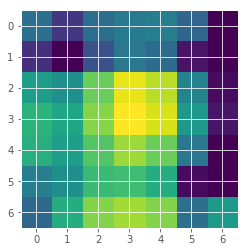

In [24]:
plt.imshow(sample_feature_map[0,:,:,0])

In [25]:
utils.show_graph(graph.as_graph_def())

In [26]:
with open('../data/training_data.pkl','rb') as fhdl:
    (out_train_image,out_train_bbs,out_train_imgsize,out_train_masks,out_train_cls_target,out_train_reg_target) = pickle.load(fhdl)

In [27]:
with open('../data/val_data.pkl','rb') as fhdl:
    (out_val_image,out_val_bbs,out_val_imgsize,out_val_masks,out_val_cls_target,out_val_reg_target) = pickle.load(fhdl)

In [28]:
box_tuple = [[16, 16],
 [32, 32],
 [48, 48],
 [64, 64],
 [96, 96],
 [128, 128],
 [192, 192],
 [256, 256],
 [512, 512]]

In [29]:
imgindex = random.randint(0,len(out_train_image))
import cv2

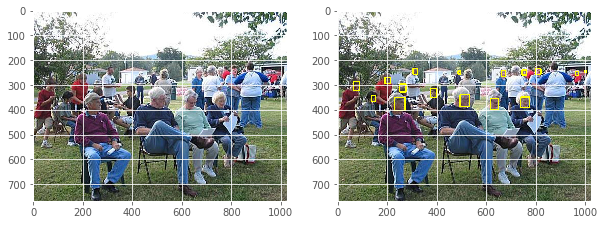

In [30]:
sample_image = plt.imread('../data/WIDER_train/images/{}'.format(out_train_image[imgindex]))
cls_target = out_train_cls_target[imgindex]
reg_target = out_train_reg_target[imgindex]
one_mask = out_train_masks[imgindex]
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(sample_image)
for _,idx,idy,idbox in np.asarray(np.where(cls_target[:,:,:,:,1] == 1)).T:
    rx,ry = idx * 32 + 16,idy * 32 + 16
    boxw,boxh = box_tuple[idbox]
    w_delta,h_delta,w_rat,h_rat = reg_target[0,idx,idy,idbox]
    x_center = int(rx + boxw * w_delta)
    y_center = int(ry + boxh * h_delta)
    
    x_width = int(boxw * np.exp(w_rat))
    y_height = int(boxh * np.exp(h_rat))
    
    cv2.rectangle(sample_image,(x_center - x_width // 2,y_center - y_height // 2),(x_center + x_width // 2,y_center + y_height // 2),(256,256,0),4)
plt.subplot(1,2,2)
plt.imshow(sample_image)

In [31]:
768 // 32

24

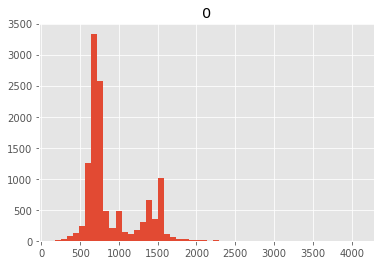

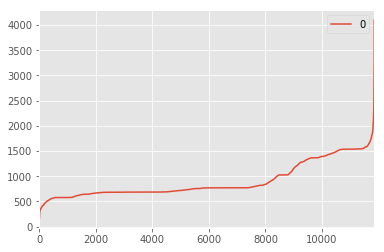

In [32]:
pd.DataFrame([i[0] for i in out_train_imgsize]).hist(bins=50)
pd.DataFrame(sorted([i[0] for i in out_train_imgsize])).plot()

In [33]:
class MultiIndex():
    def __init__(self,data):
        self.data = data
    def __getitem__(self,indexs):
        retval = []
        for i in indexs:
            retval.append(self.data[i])
        return retval
    @property
    def shape(self):
        return [len(self.data),]

In [34]:
mi = MultiIndex([1,2,3,4])
mi.shape,mi[[2,3]]

([4], [3, 4])

In [39]:
with open('./data/training_data_box.pkl','rb') as fhdl:
    training_boxes = pickle.load(fhdl)
with open('./data/val_data_box.pkl','rb') as fhdl:
    val_boxes = pickle.load(fhdl)

In [40]:
train_dataset = utils.Dataset(
    out_train_image,
    MultiIndex(out_train_masks),
    MultiIndex(out_train_cls_target),
    MultiIndex(out_train_reg_target),
    MultiIndex(training_boxes))

In [41]:
val_dataset = utils.Dataset(
    out_val_image,
    MultiIndex(out_val_masks),
    MultiIndex(out_val_cls_target),
    MultiIndex(out_val_reg_target),
    MultiIndex(val_boxes))

In [42]:
one_imgurl,one_mask,cls_target,reg_target,one_box = train_dataset.next_batch(1)

In [43]:
one_imgurl,one_mask,cls_target,reg_target = one_imgurl[0],one_mask[0],cls_target[0],reg_target[0]

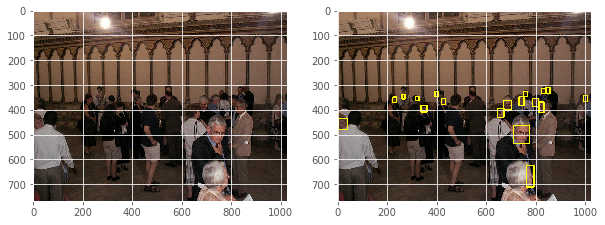

In [44]:

sample_image = plt.imread('../data/WIDER_train/images/{}'.format(one_imgurl))

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(sample_image)
for _,idx,idy,idbox in np.asarray(np.where(cls_target[:,:,:,:,1] == 1)).T:
    rx,ry = idx * 32 + 16,idy * 32 + 16
    boxw,boxh = box_tuple[idbox]
    w_delta,h_delta,w_rat,h_rat = reg_target[0,idx,idy,idbox]
    x_center = int(rx + boxw * w_delta)
    y_center = int(ry + boxh * h_delta)
    
    x_width = int(boxw * np.exp(w_rat))
    y_height = int(boxh * np.exp(h_rat))
    
    cv2.rectangle(sample_image,(x_center - x_width // 2,y_center - y_height // 2),(x_center + x_width // 2,y_center + y_height // 2),(256,256,0),4)
plt.subplot(1,2,2)
plt.imshow(sample_image)

In [45]:
if os.path.exists('models/{}'.format(MODEL_NAME)):
    print('dir exists')
else:
    os.mkdir('models/{}'.format(MODEL_NAME))

In [46]:
cls_target[:,:,:,:,1].shape

(1, 32, 24, 9)

In [47]:
np.copy(cls_target[:,:,:,:,1]).shape,one_mask.shape

((1, 32, 24, 9), (1, 32, 24, 9))

In [48]:
def add_random_spot(one_mask):
    one_mask_shape = one_mask.shape
    one_mask = one_mask.reshape(-1)
    if np.sum(one_mask) <= 64:
        num_addmask = 64
    else:
        num_addmask = int(min(np.sum(one_mask),len(one_mask) - np.sum(one_mask)))
    for i in range(num_addmask):
        one_mask[random.randint(0,len(one_mask) - 1)] = 1
    one_mask = one_mask.reshape(one_mask_shape)
    return one_mask

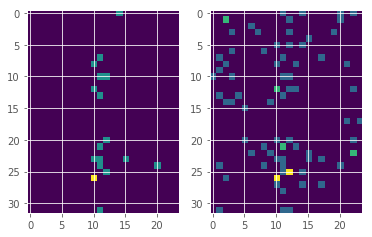

In [49]:
one_mask = np.copy(cls_target[:,:,:,:,1])
plt.subplot(1,2,1)
plt.imshow(np.sum(one_mask,-1)[0])
plt.subplot(1,2,2)
plt.imshow(np.sum(add_random_spot(one_mask),-1)[0])

In [50]:
reg_target.shape

(1, 32, 24, 9, 4)

In [51]:
cls_target.shape

(1, 32, 24, 9, 2)

In [52]:
32 * 54 * 9

15552

In [53]:
32 * 54 * 36 // 4

15552

In [61]:
with graph.as_default():
    #vgg_model.load_weights(sess)
    sess.run(tf.global_variables_initializer())
    #vgg_model.load_weights(sess)
    #sample_feature_map = sess.run(feature_map,feed_dict={input_image:np.ones(shape=(1,224,224,3))})

In [54]:
train_epoch = 1
train_batch = 0

In [252]:
start = time.time()
for i in range(100):
    one_imgurl,one_mask,cls_target,reg_target = train_dataset.next_batch(1)
    one_imgurl,one_mask,cls_target,reg_target = one_imgurl[0],one_mask[0],cls_target[0],reg_target[0]
    one_image = plt.imread('../data/WIDER_train/images/{}'.format(one_imgurl))
    one_image = np.transpose(one_image,[1,0,2])
    one_image = np.expand_dims(one_image,0)
end = time.time()
print(end - start)

2.5068888664245605


In [253]:
one_image.shape,one_mask.shape

((1, 1024, 577, 3), (1, 32, 18, 9))

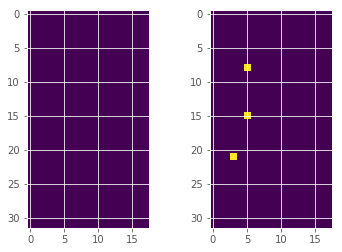

In [254]:
plt.subplot(1,2,1)
plt.imshow(np.sum(one_mask[0],axis=-1))
plt.subplot(1,2,2)
plt.imshow(np.sum(cls_target[:,:,:,:,1][0],axis=-1))

In [84]:
one_imgurl,one_mask,cls_target,reg_target = train_dataset.next_batch(1)
one_imgurl,one_mask,cls_target,reg_target = one_imgurl[0],one_mask[0],cls_target[0],reg_target[0]
one_image = plt.imread('../data/WIDER_train/images/{}'.format(one_imgurl))
one_image = np.transpose(one_image,[1,0,2])
one_image = np.expand_dims(one_image,0)

one_mask = np.copy(cls_target[:,:,:,:,1])
one_mask = add_random_spot(one_mask)
reg_target = reg_target.reshape(list(reg_target.shape[:3]) + [-1,])

np.sum(np.sum(sess.run(reg_result,feed_dict={
            learning_rate:batch_lr,
            input_image:one_image,
            mask_input:one_mask,
            cls_input:cls_target,
            reg_input:reg_target
        }).reshape(-1,4),axis=-1) * cls_target[:,:,:,:,1].reshape(-1))

In [85]:
one_cls_result,one_reg_result = sess.run([cls_result,reg_result],feed_dict={
            input_image:one_image,

        })

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff1e25bccc0>]], dtype=object)

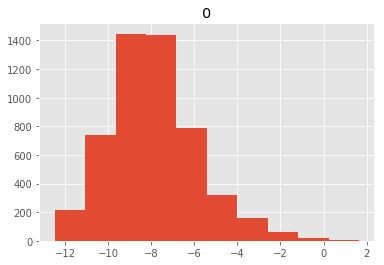

In [86]:
pd.DataFrame(one_cls_result.reshape(-1)).hist()

In [87]:
one_cls_result.shape

(1, 32, 18, 9)

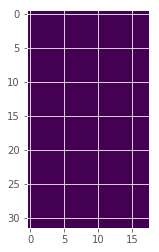

In [88]:
plt.imshow(np.sum(one_cls_result.reshape(32,-1,9) > 4,axis=-1))

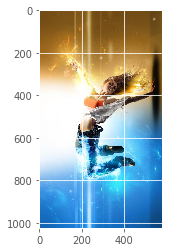

In [89]:
plt.imshow(one_image[0])

In [45]:
one_image.shape

(1, 1024, 1529, 3)

In [46]:
one_reg_result = one_reg_result.reshape(list(one_reg_result.shape[:-1]) + [9,4])

In [47]:
from nms import non_max_suppression_fast

In [48]:
np.argsort([1,2,3])

array([0, 1, 2])

In [56]:
sigmoid = lambda x: 1 / (1 + np.exp(-x))

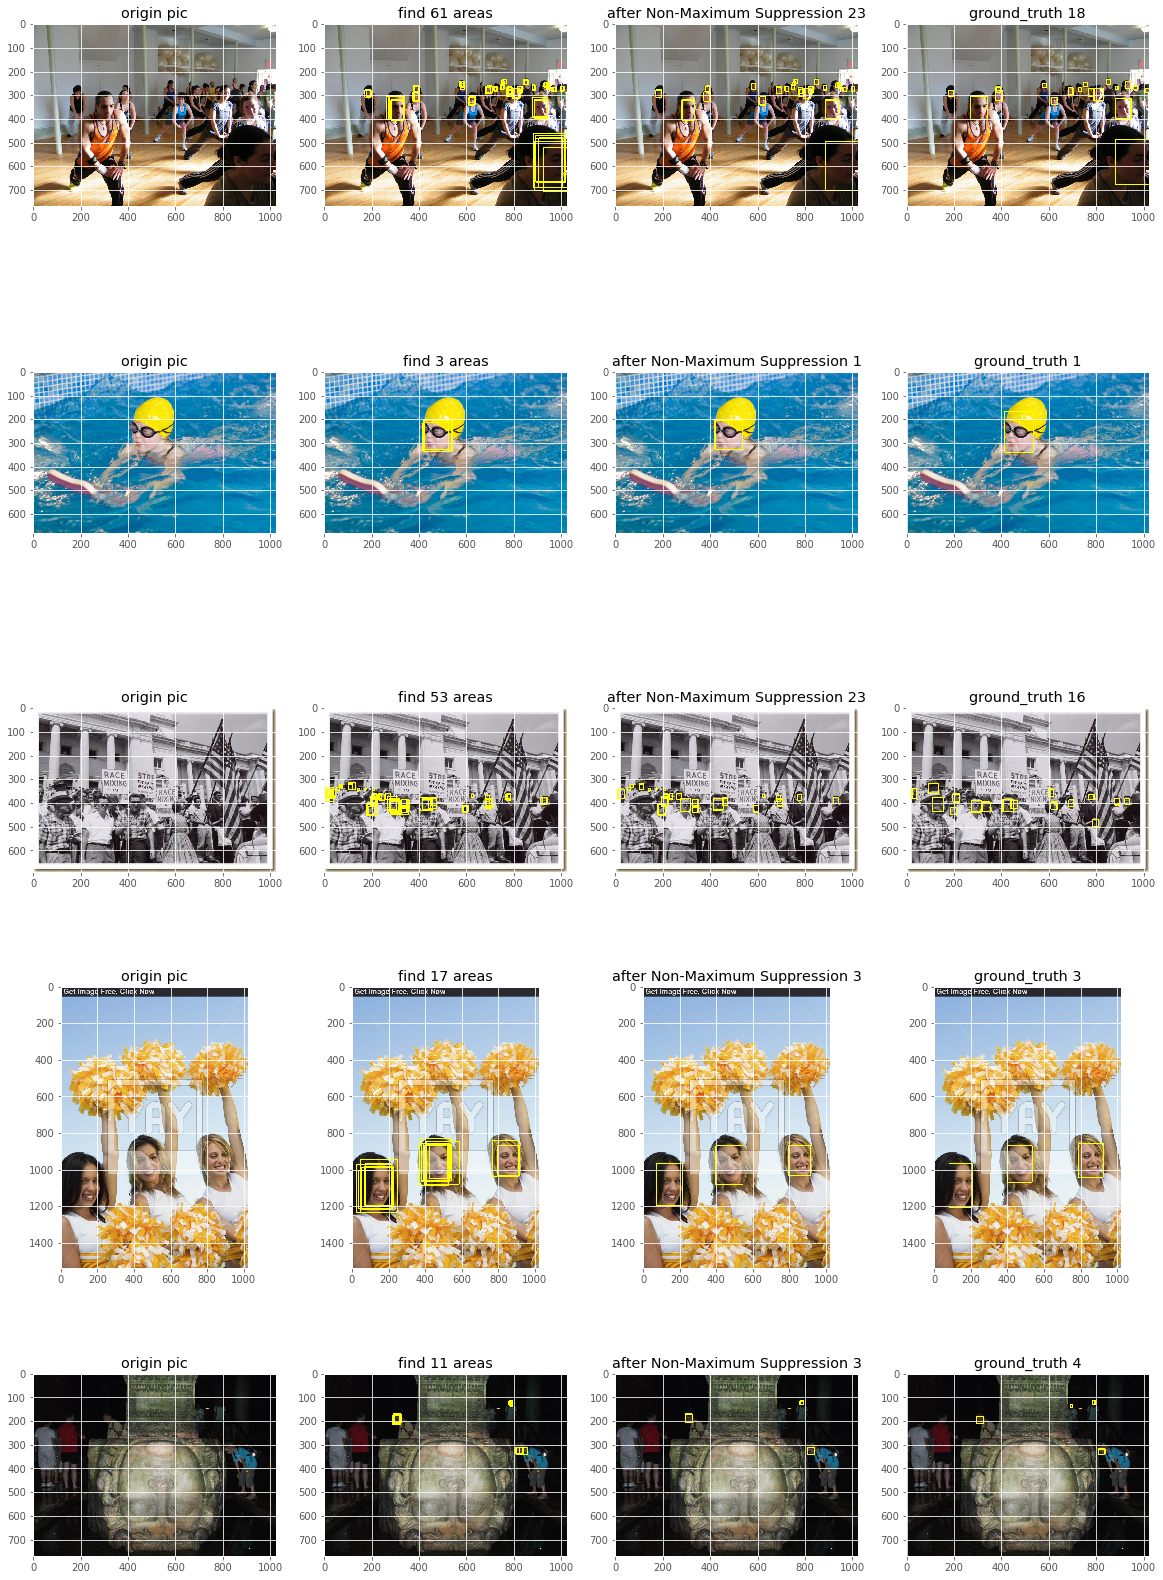

In [82]:
import cv2
pic_num = 5
plt.figure(figsize=(20,30))
for i in range(1,pic_num + 1):
    one_imgurl,one_mask,cls_target,reg_target,one_box = val_dataset.next_batch(1)
    one_imgurl,one_mask,cls_target,reg_target,one_box = one_imgurl[0],one_mask[0],cls_target[0],reg_target[0],one_box[0]
    one_image = plt.imread('../data/WIDER_val/images/{}'.format(one_imgurl))
    one_image = np.transpose(one_image,[1,0,2])
    one_image = np.expand_dims(one_image,0)

    one_mask = np.copy(cls_target[:,:,:,:,1])
    one_mask = add_random_spot(one_mask)
    reg_target = reg_target.reshape(list(reg_target.shape[:3]) + [-1,])

    one_cls_result,one_reg_result = sess.run([cls_result,reg_result],feed_dict={
                input_image:one_image,
            })
    one_reg_result = one_reg_result.reshape(list(one_reg_result.shape[:-1]) + [9,4])

    sample_image = np.copy(np.transpose(one_image[0],[1,0,2]))
    number_of_box = 100
    threshold = sorted(one_cls_result.reshape(-1))[-number_of_box]
    threshold = 0.7
    boxes = []
    boxprob = []

    
    plt.subplot(pic_num,4,1 + (i - 1) * 4)
    plt.imshow(sample_image)
    plt.title('origin pic')
    for _,idx,idy,idbox in np.asarray(np.where(sigmoid(one_cls_result) > threshold)).T:
        rx,ry = idx * 32 + 16,idy * 32 + 16
        boxw,boxh = box_tuple[idbox]
        w_delta,h_delta,w_rat,h_rat = one_reg_result[0,idx,idy,idbox]
        x_center = int(rx + boxw * w_delta)
        y_center = int(ry + boxh * h_delta)

        x_width = int(boxw * np.exp(w_rat))
        y_height = int(boxh * np.exp(h_rat))

        cv2.rectangle(sample_image,(x_center - x_width // 2,y_center - y_height // 2),(x_center + x_width // 2,y_center + y_height // 2),(256,256,0),4)
        boxes.append((x_center - x_width // 2,y_center - y_height // 2,x_center + x_width // 2,y_center + y_height // 2))
        boxprob.append(one_cls_result[0,idx,idy,idbox])
    plt.subplot(pic_num,4,2 + (i - 1) * 4)
    plt.imshow(sample_image)
    plt.title("find {} areas".format( len(np.asarray(np.where(one_cls_result > threshold)).T)))

    sample_image = np.copy(np.transpose(one_image[0],[1,0,2]))
    boxes = np.asarray(boxes)
    boxprob = sigmoid(np.asarray(boxprob))
    superssed_box = non_max_suppression_fast(boxes,0.4,probs=boxprob)
    for x1,y1,x2,y2 in superssed_box:
        cv2.rectangle(sample_image,(x1,y1),(x2,y2),(256,256,0),4)
    plt.subplot(pic_num,4,3 + (i - 1) * 4)
    plt.imshow(sample_image)
    plt.title("after Non-Maximum Suppression {}".format(len(superssed_box)))
    
    
    sample_image = np.copy(np.transpose(one_image[0],[1,0,2]))
    for m in one_box:
        x,y,w,h = m[:4]
        cv2.rectangle(sample_image,(x,y),(x + w,y + h),(256,256,0),4)
    plt.subplot(pic_num,4,4 + (i - 1) * 4)
    plt.imshow(sample_image)
    plt.title("ground_truth {}".format(len(one_box)))

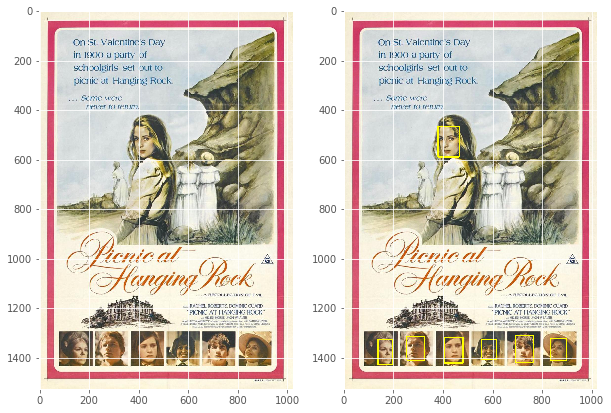

In [60]:
randindex = random.randint(0,len(training_boxes))
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
sample_image = plt.imread('../data/WIDER_train/images/' + out_train_image[randindex])
plt.imshow(sample_image)
for i in training_boxes[randindex]:
    x1,y1,w,h = i[:4]
    cv2.rectangle(sample_image,(x1,y1),(x1 + w,y1 + h),(256,256,0),4)
plt.subplot(1,2,2)
plt.imshow(sample_image)

In [61]:
train_epoch = 1
train_batch = 0

In [62]:
from nms import non_max_suppression_fast

In [63]:
def xywh2xyxy(incord):
    return incord[0],incord[1],incord[0] + incord[2],incord[1] + incord[3]

def cal_iou(box1,box2):
    x11,y11,x12,y12 = box1
    x21,y21,x22,y22 = box2
    x1 = max(x11,x21)
    x2 = min(x12,x22)
    y1 = max(y11,y21)
    y2 = min(y12,y22)
    rect_w = max(0,x2 - x1)
    rect_h = max(0,y2 - y1)
    iou = rect_w * rect_h / ((x12 - x11) * (y12 - y11) + (x22 - x21) * (y22 - y21) + 1e-7 - rect_w * rect_h)
    return iou

def twocord2centercord(thisx,thisy,thisx1,thisy1):
    this_cx = (thisx + thisx1) // 2
    this_cy = (thisy + thisy1) // 2
    this_w = (thisx1 - thisx)
    this_h = (thisy1 - thisy)
    return this_cx,this_cy,this_w,this_h

def get_four_tterms(targetcord,thiscord):
    thisx,thisy,thisx1,thisy1 = thiscord
    targetx,targety,targetx1,targety1 = targetcord
    
    this_cx,this_cy,this_w,this_h = twocord2centercord(thisx,thisy,thisx1,thisy1)
    target_cx,target_cy,target_w,target_h = twocord2centercord(targetx,targety,targetx1,targety1)
    
    tx = (target_cx - this_cx) / this_w
    ty = (target_cy - this_cy) / this_h
    tw = np.log(target_w / this_w)
    th = np.log(target_h / this_h)
    return tx,ty,tw,th

def cal_roi_target(boxes,groundtruth_boxs,iou_threshold=0.5):
    out_reg_result = np.zeros((len(boxes),4))
    out_cls_result = np.zeros((len(boxes),1))
    for ind,one_box in enumerate(boxes):
        max_box,max_iou = None,None
        for one_gtbox in groundtruth_boxs:
            if len(one_gtbox) > 4:
                one_gtbox = xywh2xyxy(one_gtbox)
            box_iou = cal_iou(one_box,one_gtbox)
            if max_iou is None or box_iou > max_iou:
                max_iou = box_iou
                max_box = one_gtbox
            # generate cls result and reg result
        if max_iou > iou_threshold:
            out_cls_result[ind,0] = 1
            tx,ty,tw,th = get_four_tterms(one_box,max_box)
            out_reg_result[ind] = np.asarray([tx,ty,tw,th])
        else:
            out_cls_result[ind,0] = 0
    return out_cls_result,out_reg_result

In [ ]:
restore = True
EPOCHS = 20
BATCH_PER_EPOCH = len(train_images) // BATCH_SIZE
begining_learning_rate = 1e-4
decay_epoch = 10

for one_epoch in range(train_epoch,EPOCHS + 1):
    train_dataset = utils.Dataset(
    out_train_image,
    MultiIndex(out_train_masks),
    MultiIndex(out_train_cls_target),
    MultiIndex(out_train_reg_target),
    MultiIndex(training_boxes))
    
    pb = utils.ProgressBar(worksum=BATCH_PER_EPOCH // 2)
    pb.startjob()
    for one_batch in range(1,BATCH_PER_EPOCH // 2 + 1):
        if restore == True and one_batch < train_batch:
            pb.auto_display = False
            pb.complete(1)
            pb.auto_display = True
            continue
        else:
            restore = False
        one_imgurl,one_mask,cls_target,reg_target,one_box = train_dataset.next_batch(1)
        one_imgurl,one_mask,cls_target,reg_target = one_imgurl[0],one_mask[0],cls_target[0],reg_target[0]
        one_image = plt.imread('../data/WIDER_train/images/{}'.format(one_imgurl))
        one_image = np.transpose(one_image,[1,0,2])
        one_image = np.expand_dims(one_image,0)
        
        try:
            batch_lr = begining_learning_rate * 0.5 ** (max(one_epoch - decay_epoch + 1,0))
            one_mask = np.copy(cls_target[:,:,:,:,1])
            one_mask = add_random_spot(one_mask)
            reg_target = reg_target.reshape(list(reg_target.shape[:3]) + [-1,])

            one_cls_result,one_reg_result,_,batch_cls_loss,batch_reg_loss,batch_total_loss,step_value,batch_train_summary_op = sess.run([cls_result,reg_result,train_op,cls_loss,reg_loss,total_loss,global_step,summary_op],feed_dict={
                learning_rate:batch_lr,
                input_image:one_image,
                mask_input:one_mask,
                cls_input:cls_target[:,:,:,:,1],
                reg_input:reg_target
            })
            #pb.info = "EPOCH {} BATCH {} lr {} cls_loss {:.2f} reg_loss {:.2f} total_loss {:.2f}".format(one_epoch,one_batch,
            #        batch_lr,batch_cls_loss,batch_reg_loss,batch_total_loss)
            train_summary_writer.add_summary(batch_train_summary_op,step_value)
        except (KeyboardInterrupt,SystemExit):
            raise
        except:
            traceback.print_exc()
            
            print()
            print()
            break
        one_reg_result = one_reg_result.reshape(list(one_reg_result.shape[:-1]) + [9,4])
        boxes = []
        boxprob = []
        for _,idx,idy,idbox in np.asarray(np.where(sigmoid(one_cls_result) > 0.5)).T:
            rx,ry = idx * 32 + 16,idy * 32 + 16
            boxw,boxh = box_tuple[idbox]
            w_delta,h_delta,w_rat,h_rat = one_reg_result[0,idx,idy,idbox]
            x_center = int(rx + boxw * w_delta)
            y_center = int(ry + boxh * h_delta)

            x_width = int(boxw * np.exp(w_rat))
            y_height = int(boxh * np.exp(h_rat))
            x1,y1,x2,y2 = x_center - x_width // 2,y_center - y_height // 2,x_center + x_width // 2,y_center + y_height // 2
            boxes.append((x1,y1,x2,y2))
            boxprob.append(one_cls_result[0,idx,idy,idbox])
        boxes = np.asarray(boxes)
        if len(boxes) > 0:
            boxes_supressed = non_max_suppression_fast(boxes,0.3,boxprob)
            boxes_supressed = np.asarray(boxes_supressed)
            boxes_supressed = boxes_supressed[:40]
            h,w = one_image.shape[1:-1]
            boxes_supressed_norm = np.asarray([[i[0] / h,i[1] / w,i[2] / h,i[3] / w] for i in boxes_supressed])
            boxes_indexes = np.asarray([0] * len(boxes_supressed_norm))
            one_roi_cls_targ,one_roi_reg_targ = cal_roi_target(boxes_supressed,one_box[0],iou_threshold=0.4)

            _,batch_roi_cls_loss,batch_roi_reg_loss,batch_roi_total_loss,batch_roi_summary_op = sess.run(
                [train_op_roi,roi_cls_loss,roi_reg_loss,roi_total_loss,summary_op_roi],feed_dict={
                input_image:one_image,
                learning_rate_roi:batch_lr,
                input_boxes:boxes_supressed_norm,
                input_box_inds:boxes_indexes,
                input_box_class:one_roi_cls_targ,
                input_box_regtarget:one_roi_reg_targ,
            })
        pb.info = "EPOCH {} BATCH {} lr {} cls_loss {:.2f} reg_loss {:.2f} total_loss {:.2f} roi_cls {:.2f} roi_reg {:.2f} roi_total {:.2f}".format(one_epoch,one_batch,
                    batch_lr,batch_cls_loss,batch_reg_loss,batch_total_loss,batch_roi_cls_loss,batch_roi_reg_loss,batch_roi_total_loss)
        train_summary_writer.add_summary(batch_roi_summary_op,step_value)
        pb.complete(1)
    with graph.as_default():
        saver = tf.train.Saver(tf.global_variables())
        saver.save(sess,"models/{}/model_{}".format(MODEL_NAME,one_epoch))

In [80]:
with graph.as_default():
    saver = tf.train.Saver(tf.global_variables())
    saver.restore(sess,"models/{}/model_latest".format(MODEL_NAME))

INFO:tensorflow:Restoring parameters from models/3_22_rpn_sigmoid_roi_rpn_joint/model_latest


In [176]:
def roi_tune(box,delta):
    (x1,y1,x2,y2) = box
    dx,dy,dw,dh = delta
    cx = (x1 + x2) // 2
    cy = (y1 + y2) // 2
    w = x2 - x1
    h = y2 - y1
    cx = cx + w * dx
    cy = cy + h * dy
    cx,cy = int(cx),int(cy)
    w = w * np.exp(dw)
    h = h * np.exp(dh)
    w,h = int(w),int(h)
    return cx - w // 2,cy - h // 2,cx + w // 2,cy + h // 2

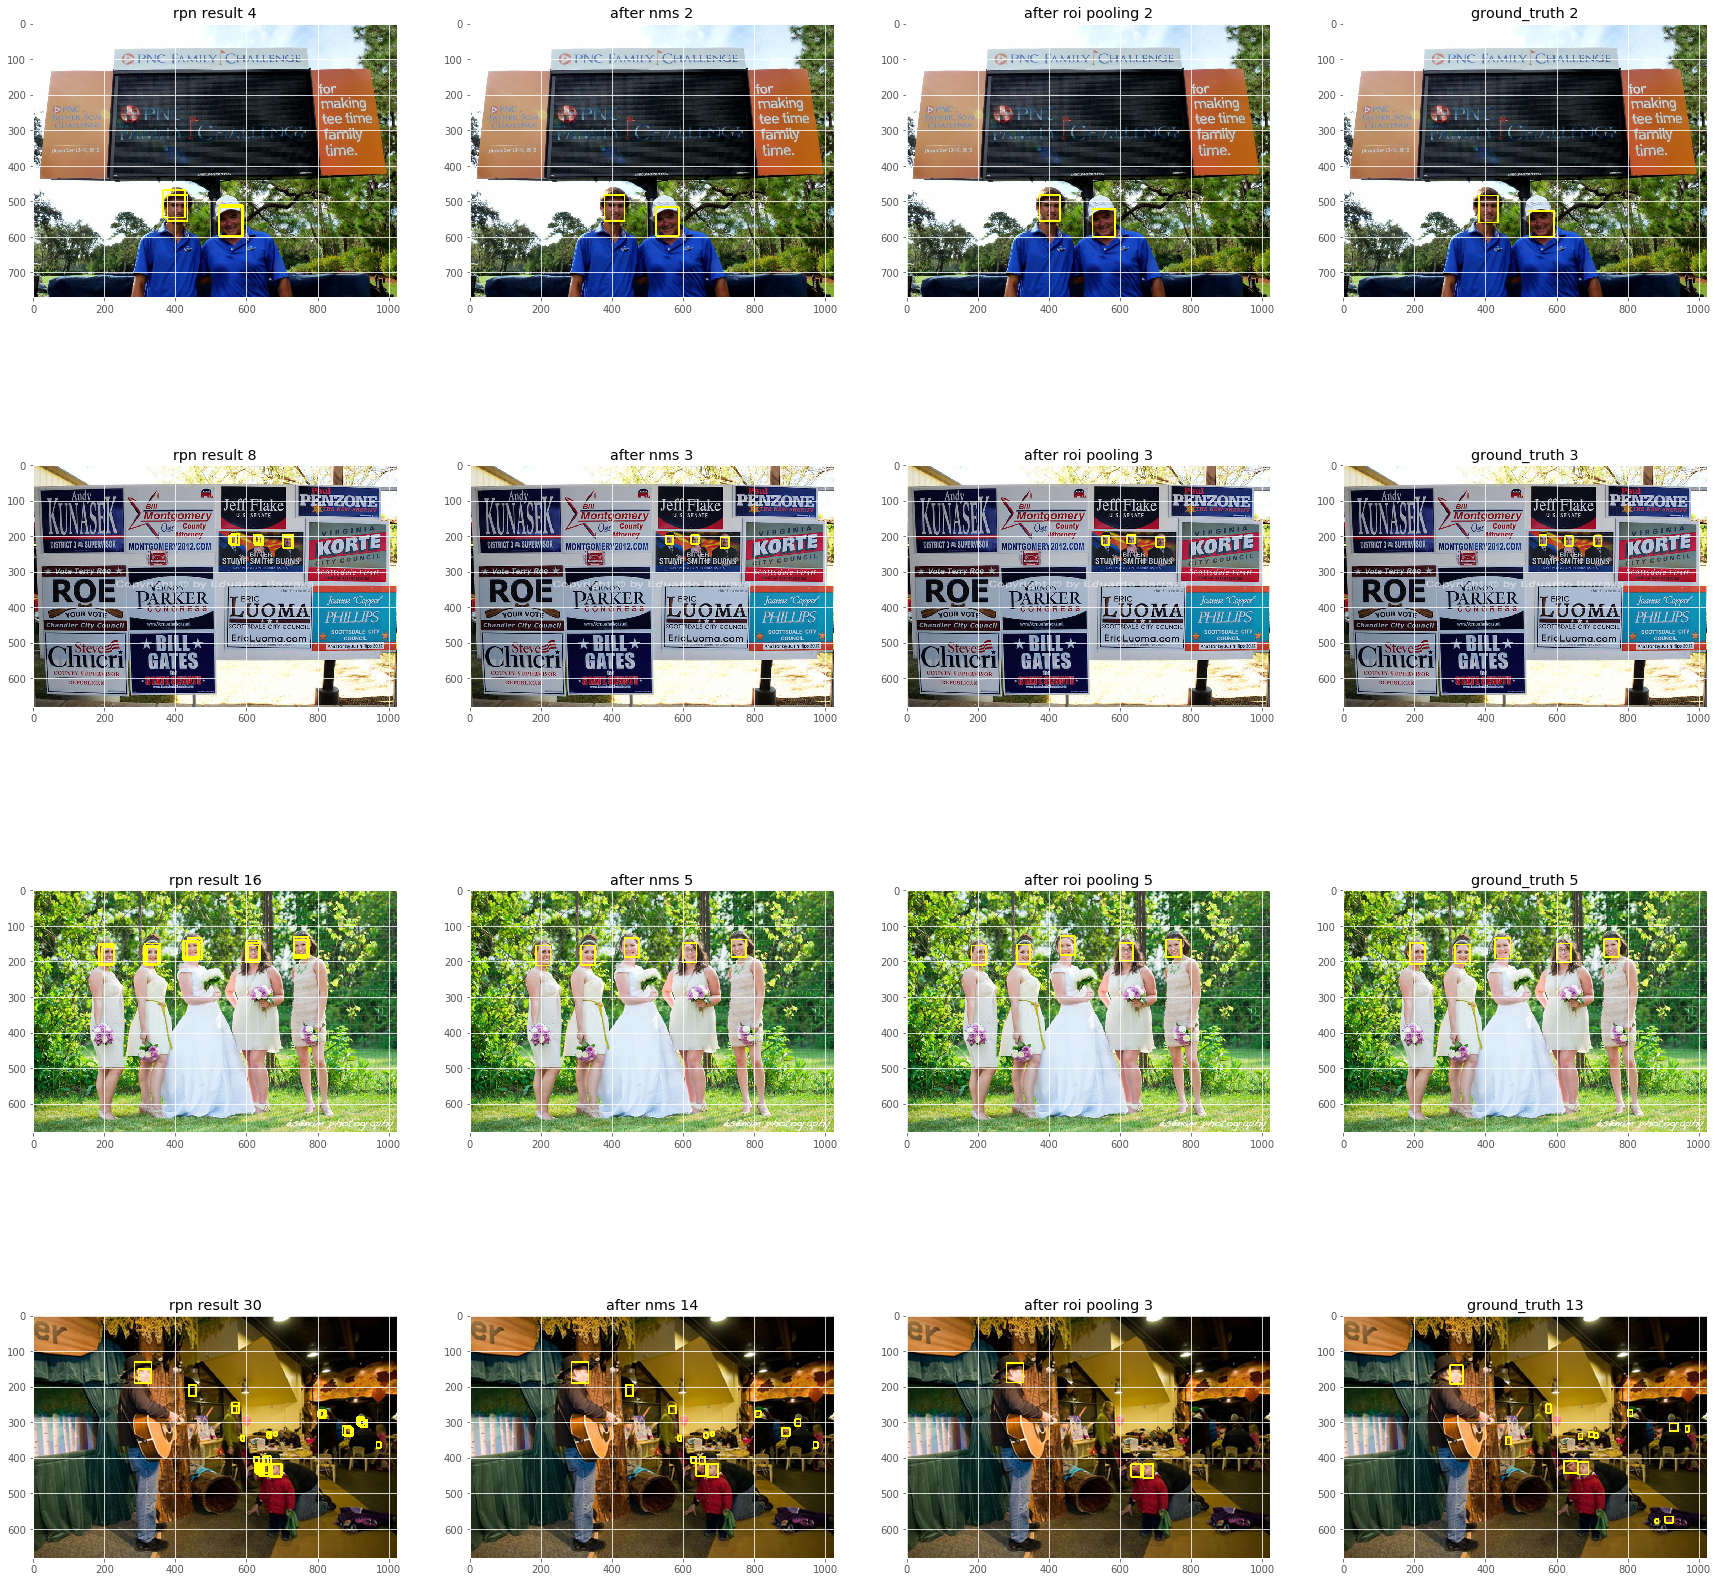

In [214]:
pic_num = 4
plt.figure(figsize=(30,30))
for pic_ind in range(1,pic_num + 1):
    one_imgurl,one_mask,cls_target,reg_target,one_box = val_dataset.next_batch(1)
    one_imgurl,one_mask,cls_target,reg_target = one_imgurl[0],one_mask[0],cls_target[0],reg_target[0]
    one_image = plt.imread('../data/WIDER_val/images/{}'.format(one_imgurl))
    
    #plt.subplot(1,5,1)
    #plt.imshow(one_image)
    #plt.title('ori image')

    one_image = np.transpose(one_image,[1,0,2])
    one_image = np.expand_dims(one_image,0)

    try:
        batch_lr = begining_learning_rate * 0.5 ** (max(one_epoch - decay_epoch + 1,0))
        one_mask = np.copy(cls_target[:,:,:,:,1])
        one_mask = add_random_spot(one_mask)
        reg_target = reg_target.reshape(list(reg_target.shape[:3]) + [-1,])

        one_cls_result,one_reg_result = sess.run([cls_result,reg_result],feed_dict={
            input_image:one_image,
        })
        #pb.info = "EPOCH {} BATCH {} lr {} cls_loss {:.2f} reg_loss {:.2f} total_loss {:.2f}".format(one_epoch,one_batch,
        #        batch_lr,batch_cls_loss,batch_reg_loss,batch_total_loss)
        train_summary_writer.add_summary(batch_train_summary_op,step_value)
    except (KeyboardInterrupt,SystemExit):
        raise

    one_reg_result = one_reg_result.reshape(list(one_reg_result.shape[:-1]) + [9,4])
    boxes = []
    boxprob = []
    sample_image = np.copy(np.transpose(one_image[0],[1,0,2]))
    for _,idx,idy,idbox in np.asarray(np.where(sigmoid(one_cls_result) > 0.5)).T:
        rx,ry = idx * 32 + 16,idy * 32 + 16
        boxw,boxh = box_tuple[idbox]
        w_delta,h_delta,w_rat,h_rat = one_reg_result[0,idx,idy,idbox]
        x_center = int(rx + boxw * w_delta)
        y_center = int(ry + boxh * h_delta)

        x_width = int(boxw * np.exp(w_rat))
        y_height = int(boxh * np.exp(h_rat))
        x1,y1,x2,y2 = x_center - x_width // 2,y_center - y_height // 2,x_center + x_width // 2,y_center + y_height // 2
        boxes.append((x1,y1,x2,y2))
        boxprob.append(one_cls_result[0,idx,idy,idbox])
        cv2.rectangle(sample_image,(x1,y1),(x2,y2),(256,256,0),4)
    plt.subplot(pic_num,4,1 + (pic_ind - 1) * 4)
    plt.imshow(sample_image)
    plt.title('rpn result {}'.format(len(boxes)))
    boxes = np.asarray(boxes)
    if len(boxes) > 0:
        boxes_supressed = non_max_suppression_fast(boxes,0.3,boxprob)
        boxes_supressed = np.asarray(boxes_supressed)
        #boxes_supressed = boxes_supressed[:40]
        h,w = one_image.shape[1:-1]
        boxes_supressed_norm = np.asarray([[i[0] / h,i[1] / w,i[2] / h,i[3] / w] for i in boxes_supressed])
        boxes_indexes = np.asarray([0] * len(boxes_supressed_norm))
        #one_roi_cls_targ,one_roi_reg_targ = cal_roi_target(boxes_supressed,one_box[0],iou_threshold=0.4)

        sample_image = np.copy(np.transpose(one_image[0],[1,0,2]))
        for x1,y1,x2,y2 in boxes_supressed:
            cv2.rectangle(sample_image,(x1,y1),(x2,y2),(256,256,0),4)
        plt.subplot(pic_num,4,2 + (pic_ind - 1) * 4)
        plt.imshow(sample_image)
        plt.title('after nms {}'.format(len(boxes_supressed)))
        batch_roi_cls_result,batch_roi_reg_result = sess.run(
            [roi_cls_result,roi_reg_result],feed_dict={
            input_image:one_image,
            input_boxes:boxes_supressed_norm,
            input_box_inds:boxes_indexes,

        })

    roi_threshold = 0.5
    roi_result_mask = np.asarray(sigmoid(batch_roi_cls_result)[:,0] > roi_threshold,dtype=np.int)
    sample_image = np.copy(np.transpose(one_image[0],[1,0,2]))
    for (x1,y1,x2,y2),delta,bxmask in zip(boxes_supressed,batch_roi_reg_result,roi_result_mask):
        if bxmask == 1:
            x1,y1,x2,y2 = roi_tune((x1,y1,x2,y2),delta)
            cv2.rectangle(sample_image,(x1,y1),(x2,y2),(256,256,0),4)
    plt.subplot(pic_num,4,3 + (pic_ind - 1) * 4)
    plt.imshow(sample_image)
    plt.title('after roi pooling {}'.format(np.sum(roi_result_mask)))

    plt.subplot(pic_num,4,4 + (pic_ind - 1) * 4)
    sample_image = np.copy(np.transpose(one_image[0],[1,0,2]))
    for bx in one_box[0]:
        x1,y1,x2,y2 = xywh2xyxy(bx)
        cv2.rectangle(sample_image,(x1,y1),(x2,y2),(256,256,0),4)
    plt.imshow(sample_image)
    plt.title('ground_truth {}'.format(len(one_box[0])))

In [1069]:
boxes_supressed_norm.shape,boxes_indexes.shape,one_roi_cls_targ.shape,one_roi_reg_targ.shape

((2, 4), (2,), (2, 1), (2, 4))

In [1066]:
input_boxes,input_box_inds,input_box_class,input_box_regtarget,roi_cls_loss,roi_reg_loss,roi_total_loss

(<tf.Tensor 'ROI/Placeholder:0' shape=(?, 4) dtype=float32>,
 <tf.Tensor 'ROI/Placeholder_1:0' shape=(?,) dtype=int32>,
 <tf.Tensor 'ROI/Placeholder_2:0' shape=(?, 1) dtype=int32>,
 <tf.Tensor 'ROI/Placeholder_3:0' shape=(?, 4) dtype=int32>,
 <tf.Tensor 'ROI/roi_layer/cls_loss/Mean:0' shape=() dtype=float32>,
 <tf.Tensor 'ROI/roi_layer/reg_loss/Mean:0' shape=() dtype=float32>,
 <tf.Tensor 'ROI/roi_layer/total_loss/add:0' shape=() dtype=float32>)

In [1051]:
one_roi_reg_targ

array([[ 0.07194245, -0.07874016, -0.18088374,  0.16644821],
       [-0.06666667, -0.025     , -0.06899287, -0.05129329]])

In [1052]:
one_roi_cls_targ

array([[ 1.],
       [ 1.]])

In [1053]:
one_box[0][0]

[550, 185, 139, 127, 0, 0, 0, 0, 0, 0]

In [1054]:
boxes_supressed

array([[571, 163, 687, 313],
       [414, 135, 442, 173]])

In [1055]:
np.log(26 / 32),np.log(38 / 43)

(-0.20763936477824449, -0.12361395596717664)

In [1056]:
sp_inimg = tf.placeholder(tf.float32,shape=(1,None,None,3))
sp_boxes = tf.placeholder(tf.float32,shape=(None,4))
sp_boxind = tf.placeholder(tf.int32,shape=(None,))
sp_outimg = tf.image.crop_and_resize(sp_inimg,sp_boxes,sp_boxind,(100,100))

In [1057]:
sp_sess = tf.Session()

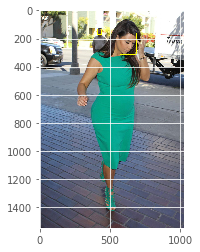

In [1058]:
spimg = np.copy(np.transpose(one_image[0],[1,0,2]))

for x1,y1,x2,y2 in boxes_supressed:
    cv2.rectangle(spimg,(x1,y1),(x2,y2),(256,256,0),3)
plt.imshow(spimg)

In [1059]:
one_box

[[[550, 185, 139, 127, 0, 0, 0, 0, 0, 0],
  [415, 135, 30, 40, 2, 0, 0, 0, 0, 0]]]

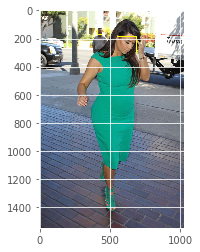

In [1060]:
spimg = np.copy(np.transpose(one_image[0],[1,0,2]))

for x1,y1,w,h,_,_,_,_,_,_ in one_box[0]:
    #x1,y1,x2,y2 = int(x1),int(y1),int(x2),int(y2)
    cv2.rectangle(spimg,(x1,y1),(x1 + w,y1 + h),(256,256,0),3)
plt.imshow(spimg)

In [1061]:
w,h,_ = spimg.shape
boxes_supressed_arr = [[i[0] / h,i[1] / w,i[2] / h,i[3] / w] for i in boxes_supressed]

In [1062]:
boxes_supressed_arr = np.asarray(boxes_supressed_arr)

In [1063]:
one_sp_outimg = sp_sess.run(sp_outimg,feed_dict={
    sp_inimg:one_image,
    sp_boxes:boxes_supressed_norm,
    sp_boxind:np.asarray([0] * len(boxes_supressed_norm))
})

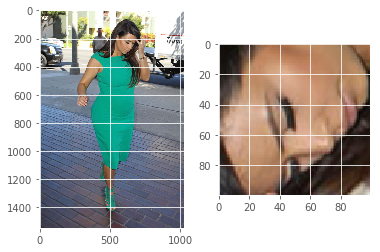

In [1064]:
plt.subplot(1,2,1)
plt.imshow(np.transpose(one_image[0],[1,0,2]))
plt.subplot(1,2,2)
plt.imshow(np.array(one_sp_outimg[0],dtype=np.uint8))

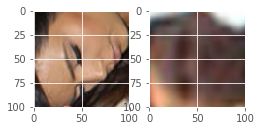

In [1065]:
plt.figure(figsize=(10,10))
for i,sp_oneimage in enumerate(one_sp_outimg[:5]):
    plt.subplot(1,5,i + 1)
    plt.imshow(np.asarray(sp_oneimage,dtype=np.uint8))